In [6]:
import random, time, heapq, itertools
from collections import deque, defaultdict

# ---------- Puzzle model ----------
GOAL = (1, 2, 3, 4, 5, 6, 7, 8, 0)
MOVES = {
    0: (1, 3),
    1: (0, 2, 4),
    2: (1, 5),
    3: (0, 4, 6),
    4: (1, 3, 5, 7),
    5: (2, 4, 8),
    6: (3, 7),
    7: (4, 6, 8),
    8: (5, 7)
}


def is_solvable(state):
    arr = [x for x in state if x != 0]
    inv = sum(1 for i in range(len(arr)) for j in range(i + 1, len(arr))
              if arr[i] > arr[j])
    return inv % 2 == 0


def neighbors(state):
    z = state.index(0)
    for nb in MOVES[z]:
        s = list(state)
        s[z], s[nb] = s[nb], s[z]
        yield tuple(s), 1  # step cost 1


def random_start(max_shuffles=60):
    s = list(GOAL)
    z = s.index(0)
    for _ in range(random.randint(20, max_shuffles)):
        choices = MOVES[z]
        nb = random.choice(choices)
        s[z], s[nb] = s[nb], s[z]
        z = nb
    return tuple(s)


# ---------- Generic search framework ----------
class Result:
    def __init__(self, found, path_cost, nodes_expanded, depth, secs, path):
        self.found = found
        self.path_cost = path_cost
        self.nodes_expanded = nodes_expanded
        self.depth = depth
        self.secs = secs
        self.path = path


def reconstruct(parents, s):
    path = [s]
    while s in parents:
        s = parents[s]
        path.append(s)
    path.reverse()
    return path


def run_search(start, algo="bfs", heuristic=None):
    t0 = time.perf_counter()
    nodes_expanded = 0

    if start == GOAL:
        return Result(True, 0, 0, 0, 0.0, [start])

    if algo == "bfs":
        Q = deque([start])
        parents = {}
        seen = {start}

        while Q:
            s = Q.popleft()
            nodes_expanded += 1
            for nxt, c in neighbors(s):
                if nxt in seen:
                    continue
                parents[nxt] = s
                seen.add(nxt)
                if nxt == GOAL:
                    path = reconstruct(parents, nxt)
                    return Result(True, len(path) - 1, nodes_expanded,
                                  len(path) - 1, time.perf_counter() - t0, path)
                Q.append(nxt)
        return Result(False, -1, nodes_expanded, -1, time.perf_counter() - t0, [])

    if algo == "dfs":
        stack = [start]
        parents = {}
        seen = {start}

        while stack:
            s = stack.pop()
            nodes_expanded += 1
            for nxt, c in neighbors(s):
                if nxt in seen:
                    continue
                parents[nxt] = s
                seen.add(nxt)
                if nxt == GOAL:
                    path = reconstruct(parents, nxt)
                    return Result(True, len(path) - 1, nodes_expanded,
                                  len(path) - 1, time.perf_counter() - t0, path)
                stack.append(nxt)
        return Result(False, -1, nodes_expanded, -1, time.perf_counter() - t0, [])

    if algo in ("ucs", "astar"):
        g = defaultdict(lambda: float("inf"))
        g[start] = 0
        parents = {}
        cnt = itertools.count()

        def h(s):
            if heuristic is None:
                return 0
            return heuristic(s)

        open_heap = [(g[start] + h(start), next(cnt), start)]
        closed = set()

        while open_heap:
            f, _, s = heapq.heappop(open_heap)
            if s in closed:
                continue
            closed.add(s)
            nodes_expanded += 1
            if s == GOAL:
                path = reconstruct(parents, s)
                return Result(True, g[s], nodes_expanded, len(path) - 1,
                              time.perf_counter() - t0, path)

            for nxt, c in neighbors(s):
                tentative = g[s] + c
                if tentative < g[nxt]:
                    g[nxt] = tentative
                    parents[nxt] = s
                    heapq.heappush(open_heap, (
                        tentative + (0 if algo == "ucs" else h(nxt)),
                        next(cnt),
                        nxt
                    ))

        return Result(False, -1, nodes_expanded, -1, time.perf_counter() - t0, [])

    raise ValueError("Unknown algo")


# ---------- Example usage ----------
def manhattan_distance(state):
    """Heuristic for A*: sum of distances from current to goal positions."""
    dist = 0
    for i, val in enumerate(state):
        if val == 0:
            continue
        gx, gy = divmod(GOAL.index(val), 3)
        sx, sy = divmod(i, 3)
        dist += abs(gx - sx) + abs(gy - sy)
    return dist


if __name__ == "__main__":
    start = random_start()
    print("Start state:", start)
    if not is_solvable(start):
        print("Not solvable!")
    else:
        print("\nSolving using BFS...")
        r = run_search(start, "bfs")
        print(f"Found: {r.found}, Cost: {r.path_cost}, Expanded: {r.nodes_expanded}, Depth: {r.depth}, Time: {r.secs:.3f}s")

        print("\nSolving using A* (Manhattan)...")
        r = run_search(start, "astar", heuristic=manhattan_distance)
        print(f"Found: {r.found}, Cost: {r.path_cost}, Expanded: {r.nodes_expanded}, Depth: {r.depth}, Time: {r.secs:.3f}s")

Start state: (0, 1, 3, 7, 2, 4, 5, 8, 6)

Solving using BFS...
Found: True, Cost: 10, Expanded: 330, Depth: 10, Time: 0.001s

Solving using A* (Manhattan)...
Found: True, Cost: 10, Expanded: 20, Depth: 10, Time: 0.000s


In [7]:
import random, time, heapq, itertools
from collections import deque, defaultdict

# ---------- Puzzle model ----------
GOAL = (1, 2, 3, 4, 5, 6, 7, 8, 0)
MOVES = {
    0: (1, 3), 1: (0, 2, 4), 2: (1, 5),
    3: (0, 4, 6), 4: (1, 3, 5, 7), 5: (2, 4, 8),
    6: (3, 7), 7: (4, 6, 8), 8: (5, 7)
}

def is_solvable(state):
    arr = [x for x in state if x != 0]
    inv = sum(1 for i in range(len(arr)) for j in range(i + 1, len(arr)) if arr[i] > arr[j])
    return inv % 2 == 0

def neighbors(state):
    z = state.index(0)
    for nb in MOVES[z]:
        s = list(state)
        s[z], s[nb] = s[nb], s[z]
        yield tuple(s), 1

def random_start(max_shuffles=60):
    s = list(GOAL)
    z = s.index(0)
    for _ in range(random.randint(20, max_shuffles)):
        nb = random.choice(MOVES[z])
        s[z], s[nb] = s[nb], s[z]
        z = nb
    return tuple(s)

# ---------- Generic search framework ----------
class Result:
    def __init__(self, found, path_cost, nodes_expanded, depth, secs, path):
        self.found = found
        self.path_cost = path_cost
        self.nodes_expanded = nodes_expanded
        self.depth = depth
        self.secs = secs
        self.path = path

def reconstruct(parents, s):
    path = [s]
    while s in parents:
        s = parents[s]
        path.append(s)
    path.reverse()
    return path

def run_search(start, algo="bfs", heuristic=None):
    t0 = time.perf_counter()
    nodes_expanded = 0

    if start == GOAL:
        return Result(True, 0, 0, 0, 0.0, [start])

    if algo == "bfs":
        Q = deque([start])
        parents = {}
        seen = {start}
        while Q:
            s = Q.popleft()
            nodes_expanded += 1
            for nxt, c in neighbors(s):
                if nxt in seen:
                    continue
                parents[nxt] = s
                seen.add(nxt)
                if nxt == GOAL:
                    path = reconstruct(parents, nxt)
                    return Result(True, len(path)-1, nodes_expanded, len(path)-1, time.perf_counter()-t0, path)
                Q.append(nxt)
        return Result(False, -1, nodes_expanded, -1, time.perf_counter()-t0, [])

    if algo == "dfs":
        stack = [start]
        parents = {}
        seen = {start}
        while stack:
            s = stack.pop()
            nodes_expanded += 1
            for nxt, c in neighbors(s):
                if nxt in seen:
                    continue
                parents[nxt] = s
                seen.add(nxt)
                if nxt == GOAL:
                    path = reconstruct(parents, nxt)
                    return Result(True, len(path)-1, nodes_expanded, len(path)-1, time.perf_counter()-t0, path)
                stack.append(nxt)
        return Result(False, -1, nodes_expanded, -1, time.perf_counter()-t0, [])

    if algo in ("ucs", "astar"):
        g = defaultdict(lambda: float("inf"))
        g[start] = 0
        parents = {}
        cnt = itertools.count()

        def h(s):
            return 0 if heuristic is None else heuristic(s)

        open_heap = [(g[start] + h(start), next(cnt), start)]
        closed = set()

        while open_heap:
            f, _, s = heapq.heappop(open_heap)
            if s in closed:
                continue
            closed.add(s)
            nodes_expanded += 1
            if s == GOAL:
                path = reconstruct(parents, s)
                return Result(True, g[s], nodes_expanded, len(path)-1, time.perf_counter()-t0, path)
            for nxt, c in neighbors(s):
                tentative = g[s] + c
                if tentative < g[nxt]:
                    g[nxt] = tentative
                    parents[nxt] = s
                    heapq.heappush(open_heap, (tentative + (0 if algo=="ucs" else h(nxt)), next(cnt), nxt))
        return Result(False, -1, nodes_expanded, -1, time.perf_counter()-t0, [])

    raise ValueError("Unknown algo")

# ---------- Heuristics ----------
goal_pos = {v: i for i, v in enumerate(GOAL)}

def manhattan(s):
    dist = 0
    for idx, val in enumerate(s):
        if val == 0: continue
        gi = goal_pos[val]
        r1, c1 = divmod(idx, 3)
        r2, c2 = divmod(gi, 3)
        dist += abs(r1 - r2) + abs(c1 - c2)
    return dist

def linear_conflict(s):
    dist = manhattan(s)
    # rows
    for r in range(3):
        row = s[3*r:3*r+3]
        goal_row = [1+3*r, 2+3*r, 3+3*r]
        tiles = [x for x in row if x in goal_row]
        for i in range(len(tiles)):
            for j in range(i+1, len(tiles)):
                if goal_row.index(tiles[i]) > goal_row.index(tiles[j]):
                    dist += 2
    # cols
    for c in range(3):
        col = s[c::3]
        goal_col = [c+1, c+4, c+7]
        tiles = [x for x in col if x in goal_col]
        for i in range(len(tiles)):
            for j in range(i+1, len(tiles)):
                if goal_col.index(tiles[i]) > goal_col.index(tiles[j]):
                    dist += 2
    return dist

# ---------- Experiments ----------
def run_experiments(num=5, seed=7):
    random.seed(seed)
    starts = []
    while len(starts) < num:
        s = random_start()
        if is_solvable(s) and s not in starts:
            starts.append(s)

    rows = []
    for i, s in enumerate(starts, 1):
        for algo in ["bfs", "dfs", "ucs"]:
            res = run_search(s, algo=algo)
            rows.append((f"Case{i}", algo.upper(), res.path_cost, res.nodes_expanded, res.secs))
        for name, h in [("A*-Manhattan", manhattan), ("A*-LinearConflict", linear_conflict)]:
            res = run_search(s, algo="astar", heuristic=h)
            rows.append((f"Case{i}", name, res.path_cost, res.nodes_expanded, res.secs))
    return rows

if __name__ == "__main__":
    from pprint import pprint
    rows = run_experiments()
    print("Case, Method, PathCost, NodesExpanded, Time(s)")
    for r in rows:
        print(",".join([str(x) for x in r]))

    # Simple averages
    import statistics as st
    def agg(label):
        subset = [r for r in rows if r[1] == label]
        return st.mean([r[3] for r in subset]), st.mean([r[4] for r in subset])

    u_nodes, u_time = agg("UCS")
    m_nodes, m_time = agg("A*-Manhattan")
    l_nodes, l_time = agg("A*-LinearConflict")

    print("\nAverages over 5 starts:")
    print(f"UCS : nodes={u_nodes:.0f}, time={u_time:.4f}s")
    print(f"A* M : nodes={m_nodes:.0f}, time={m_time:.4f}s")
    print(f"A* LC: nodes={l_nodes:.0f}, time={l_time:.4f}s")

    print("\nHeuristic notes:")
    print("- Manhattan is admissible & consistent for 8-puzzle (each move shifts a tile by 1 Manhattan unit).")
    print("- Linear Conflict = Manhattan + 2 per pair in reversed row/col order; still admissible & consistent.")

Case, Method, PathCost, NodesExpanded, Time(s)
Case1,BFS,10,371,0.000523500000099375
Case1,DFS,20688,23224,0.04113772899995638
Case1,UCS,10,601,0.0018494499997814273
Case1,A*-Manhattan,10,26,0.00016454999990855868
Case1,A*-LinearConflict,10,23,0.00032117999990077806
Case2,BFS,4,13,2.37300000662799e-05
Case2,DFS,214,232,0.0003026599999884638
Case2,UCS,4,27,6.026000005476817e-05
Case2,A*-Manhattan,4,5,3.4710000136328745e-05
Case2,A*-LinearConflict,4,5,7.365999999819905e-05
Case3,BFS,20,34664,0.05269195899995793
Case3,DFS,22492,25224,0.05489169900010893
Case3,UCS,20,50118,0.1877219549999154
Case3,A*-Manhattan,20,756,0.0043475699999362405
Case3,A*-LinearConflict,20,437,0.0044669100000191975
Case4,BFS,17,9418,0.013116079999917929
Case4,DFS,47999,54877,0.09528549699984978
Case4,UCS,17,14346,0.047079379000024346
Case4,A*-Manhattan,17,80,0.0005578600000717415
Case4,A*-LinearConflict,17,63,0.0008058399998844834
Case5,BFS,4,14,2.538000012464181e-05
Case5,DFS,46136,52626,0.09439041800010273
Case5

PATH: [(1, 1), (1, 2), (1, 3), (1, 4), (2, 4), (2, 3), (1, 3), (1, 2), (1, 1)]
GOT GOLD: True
SAFE: [(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 4)]
INFERRED PITS: [(3, 3)]

Derived sentences:
- From ¬B(1,1) infer SAFE(2, 1)
- From ¬B(1,1) infer SAFE(1, 2)
- From ¬B(1,2) infer SAFE(2, 2)
- From ¬B(1,2) infer SAFE(1, 3)
- From ¬B(1,3) infer SAFE(2, 3)
- From ¬B(1,3) infer SAFE(1, 4)
- From ¬B(1,4) infer SAFE(2, 4)
- From ¬B(2,4) infer SAFE(3, 4)
- GLITTER at (2, 3) ⇒ grab gold
- B(2,3) ⇒ at least one of [(3, 3)] is a Pit
- Only (3, 3) fits B(2, 3) ⇒ PIT(3, 3)


/tmp/ipython-input-1291487444.py:177: UserWarning: Glyph 129001 (\N{LARGE GREEN SQUARE}) missing from font(s) DejaVu Sans.
  plt.pause(0.8)
/tmp/ipython-input-1291487444.py:177: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.pause(0.8)
/tmp/ipython-input-1291487444.py:177: UserWarning: Glyph 128128 (\N{SKULL}) missing from font(s) DejaVu Sans.
  plt.pause(0.8)
/tmp/ipython-input-1291487444.py:177: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  plt.pause(0.8)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129001 (\N{LARGE GREEN SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: User

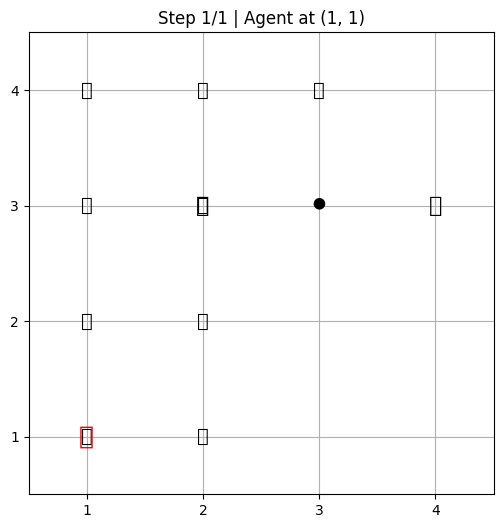

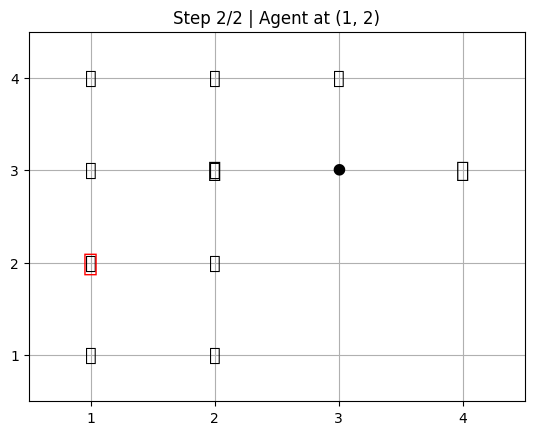

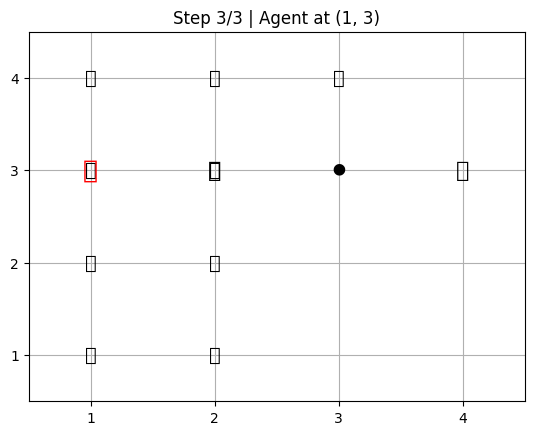

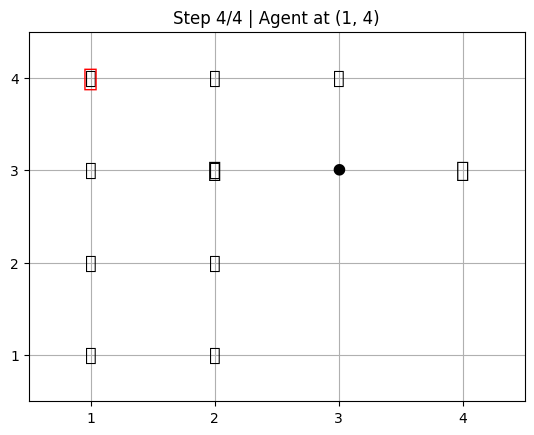

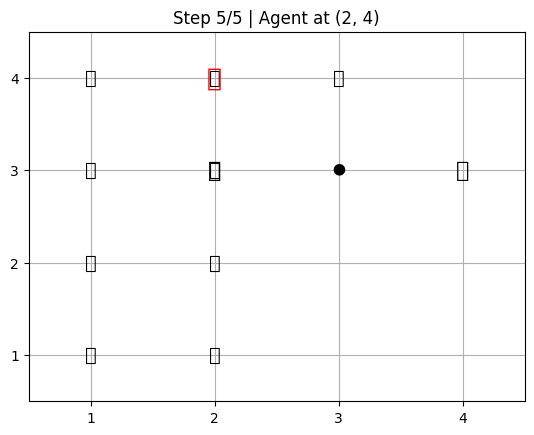

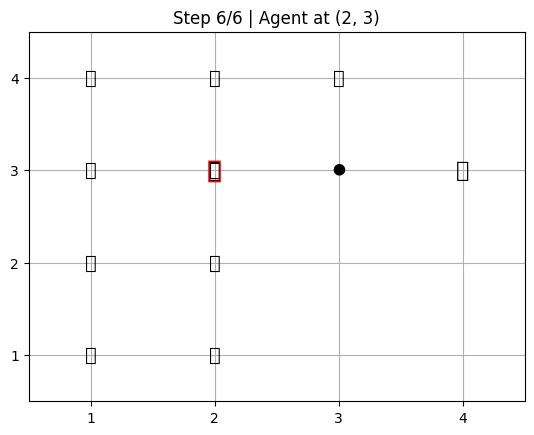

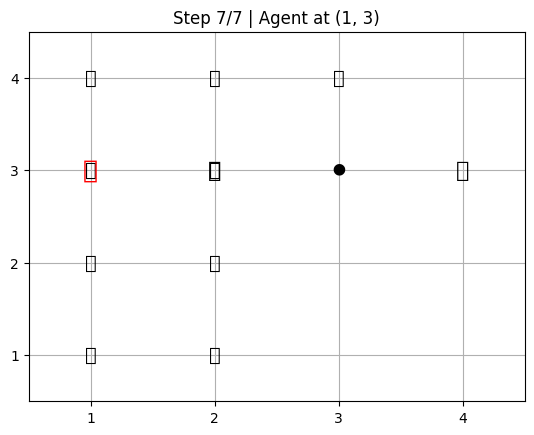

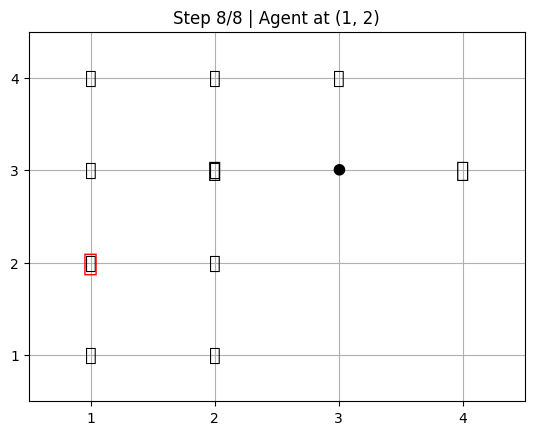

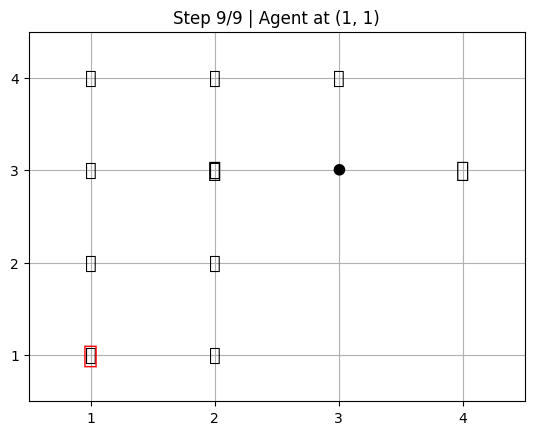

In [8]:
import matplotlib.pyplot as plt
import time
from collections import deque

# Directions (4-connected grid)
DIRS = [(1,0), (-1,0), (0,1), (0,-1)]

def in_bounds(x, y): return 1 <= x <= 4 and 1 <= y <= 4

def neighbors(x, y):
    for dx, dy in DIRS:
        nx, ny = x + dx, y + dy
        if in_bounds(nx, ny):
            yield (nx, ny)

# ---------- Knowledge Base ----------
class KB:
    """Lightweight propositional KB for pit/breeze inference"""
    def __init__(self):
        self.safe = set()
        self.pit = set()
        self.possible = {}
        self.logs = []

    def assert_no_breeze(self, x, y):
        for n in neighbors(x, y):
            if n not in self.safe and n not in self.pit:
                self.safe.add(n)
                self.logs.append(f"From ¬B({x},{y}) infer SAFE{n}")

    def assert_breeze(self, x, y):
        if (x, y) not in self.possible:
            cands = {n for n in neighbors(x, y)
                     if n not in self.safe and n not in self.pit}
            self.possible[(x, y)] = cands
            self.logs.append(f"B({x},{y}) ⇒ at least one of {sorted(cands)} is a Pit")

    def mark_safe(self, cell):
        if cell in self.safe:
            return
        self.safe.add(cell)
        for k in list(self.possible):
            if cell in self.possible[k]:
                self.possible[k].remove(cell)
                self.logs.append(f"Since {cell} is SAFE, remove from pit-candidates of {k}")

    def deduce(self):
        changed = True
        while changed:
            changed = False
            for k, cands in list(self.possible.items()):
                cands = {c for c in cands if c not in self.safe and c not in self.pit}
                self.possible[k] = cands
                if len(cands) == 1:
                    p = next(iter(cands))
                    if p not in self.pit:
                        self.pit.add(p)
                        changed = True
                        self.logs.append(f"Only {p} fits B{tuple(k)} ⇒ PIT{p}")
                elif len(cands) == 0:
                    pass

# ---------- World Definition ----------
class World:
    """4x4 Wumpus World with pits, Wumpus, and gold"""
    def __init__(self, pits={(3,1),(3,3)}, wumpus=(4,3), gold=(2,3)):
        self.pits = set(pits)
        self.wumpus = wumpus
        self.gold = gold

    def percept(self, x, y):
        breeze = any(n in self.pits for n in neighbors(x, y))
        stench = any(n == self.wumpus for n in neighbors(x, y))
        glitter = (x, y) == self.gold
        return {"breeze": breeze, "stench": stench, "glitter": glitter}

# ---------- Agent Logic ----------
def agent_run(world, start=(1,1)):
    kb = KB()
    path = [start]
    visited = {start}
    have_gold = False
    breezy = set()

    def process_cell(c):
        nonlocal have_gold
        x, y = c
        p = world.percept(x, y)
        if p["glitter"]:
            have_gold = True
            kb.logs.append(f"GLITTER at {c} ⇒ grab gold")
        if p["breeze"]:
            kb.assert_breeze(x, y)
            breezy.add(c)
        else:
            kb.assert_no_breeze(x, y)
        kb.mark_safe(c)
        kb.deduce()

    process_cell(start)

    # Explore safely
    while True:
        options = [n for n in neighbors(*path[-1])
                   if n in kb.safe and n not in visited]
        if not options:
            break
        nxt = sorted(options)[0]
        path.append(nxt)
        visited.add(nxt)
        process_cell(nxt)
        if have_gold and nxt == (1,1):
            break

        # If gold found, plan to return home
        if have_gold and nxt != (1,1):
            def manhattan(a,b): return abs(a[0]-b[0])+abs(a[1]-b[1])
            current = nxt
            while current != (1,1):
                cands = [n for n in neighbors(*current) if n in kb.safe]
                if not cands: break
                best = min(cands, key=lambda t: (manhattan(t,(1,1)), t))
                path.append(best)
                visited.add(best)
                current = best
            break

    return {
        "path": path,
        "have_gold": have_gold,
        "safe": sorted(kb.safe),
        "pits_inferred": sorted(kb.pit),
        "breezy": breezy,
        "log": kb.logs,
        "world": world
    }

# ---------- Visualization ----------
def draw_world(state, step):
    world = state["world"]
    path = state["path"][:step+1]
    pits = world.pits
    wumpus = world.wumpus
    gold = world.gold
    safe = state["safe"]
    inferred_pits = set(state["pits_inferred"])
    breezy = state["breezy"]

    plt.clf()
    ax = plt.gca()
    ax.set_xlim(0.5, 4.5)
    ax.set_ylim(0.5, 4.5)
    ax.set_xticks(range(1,5))
    ax.set_yticks(range(1,5))
    ax.grid(True)

    # Draw base
    for x in range(1,5):
        for y in range(1,5):
            if (x,y) in inferred_pits:
                plt.text(x, y, "⚫", ha='center', va='center', fontsize=18)
            elif (x,y) in safe:
                plt.text(x, y, "🟩", ha='center', va='center', fontsize=14)
            elif (x,y) in breezy:
                plt.text(x, y, "💨", ha='center', va='center', fontsize=14)

    # Gold and Wumpus
    gx, gy = gold
    wx, wy = wumpus
    plt.text(gx, gy, "💰", ha='center', va='center', fontsize=16)
    plt.text(wx, wy, "💀", ha='center', va='center', fontsize=16)

    # Agent
    ax.text(path[-1][0], path[-1][1], "🧍", ha='center', va='center', fontsize=18, color="red")

    ax.set_title(f"Step {step+1}/{len(path)} | Agent at {path[-1]}")
    plt.pause(0.8)

# ---------- Main ----------
if __name__ == "__main__":
    world = World(pits={(3,1),(3,3)}, wumpus=(4,3), gold=(2,3))
    out = agent_run(world)

    print("PATH:", out["path"])
    print("GOT GOLD:", out["have_gold"])
    print("SAFE:", out["safe"])
    print("INFERRED PITS:", out["pits_inferred"])
    print("\nDerived sentences:")
    for line in out["log"]:
        print("-", line)

    plt.figure(figsize=(6,6))
    for i in range(len(out["path"])):
        draw_world(out, i)
    plt.show()

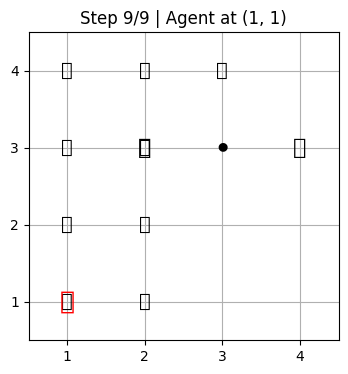


✅ Simulation finished.


In [10]:
# --- Wumpus World Agent Visualization for Google Colab ---

import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time
from collections import deque

# Directions
DIRS = [(1,0), (-1,0), (0,1), (0,-1)]
def in_bounds(x, y): return 1 <= x <= 4 and 1 <= y <= 4
def neighbors(x, y):
    for dx, dy in DIRS:
        nx, ny = x + dx, y + dy
        if in_bounds(nx, ny): yield (nx, ny)

# ---------- Knowledge Base ----------
class KB:
    def __init__(self):
        self.safe = set()
        self.pit = set()
        self.possible = {}
        self.logs = []

    def assert_no_breeze(self, x, y):
        for n in neighbors(x, y):
            if n not in self.safe and n not in self.pit:
                self.safe.add(n)
                self.logs.append(f"From ¬B({x},{y}) infer SAFE{n}")

    def assert_breeze(self, x, y):
        if (x, y) not in self.possible:
            cands = {n for n in neighbors(x, y)
                     if n not in self.safe and n not in self.pit}
            self.possible[(x, y)] = cands
            self.logs.append(f"B({x},{y}) ⇒ at least one of {sorted(cands)} is a Pit")

    def mark_safe(self, cell):
        if cell in self.safe: return
        self.safe.add(cell)
        for k in list(self.possible):
            if cell in self.possible[k]:
                self.possible[k].remove(cell)
                self.logs.append(f"Since {cell} is SAFE, remove from pit-candidates of {k}")

    def deduce(self):
        changed = True
        while changed:
            changed = False
            for k, cands in list(self.possible.items()):
                cands = {c for c in cands if c not in self.safe and c not in self.pit}
                self.possible[k] = cands
                if len(cands) == 1:
                    p = next(iter(cands))
                    if p not in self.pit:
                        self.pit.add(p)
                        changed = True
                        self.logs.append(f"Only {p} fits B{tuple(k)} ⇒ PIT{p}")

# ---------- World ----------
class World:
    def __init__(self, pits={(3,1),(3,3)}, wumpus=(4,3), gold=(2,3)):
        self.pits = set(pits)
        self.wumpus = wumpus
        self.gold = gold

    def percept(self, x, y):
        breeze = any(n in self.pits for n in neighbors(x, y))
        stench = any(n == self.wumpus for n in neighbors(x, y))
        glitter = (x, y) == self.gold
        return {"breeze": breeze, "stench": stench, "glitter": glitter}

# ---------- Agent ----------
def agent_run(world, start=(1,1)):
    kb = KB()
    path = [start]
    visited = {start}
    have_gold = False
    breezy = set()

    def process_cell(c):
        nonlocal have_gold
        x, y = c
        p = world.percept(x, y)
        if p["glitter"]:
            have_gold = True
            kb.logs.append(f"GLITTER at {c} ⇒ grab gold")
        if p["breeze"]:
            kb.assert_breeze(x, y)
            breezy.add(c)
        else:
            kb.assert_no_breeze(x, y)
        kb.mark_safe(c)
        kb.deduce()

    process_cell(start)

    while True:
        options = [n for n in neighbors(*path[-1])
                   if n in kb.safe and n not in visited]
        if not options:
            break
        nxt = sorted(options)[0]
        path.append(nxt)
        visited.add(nxt)
        process_cell(nxt)
        if have_gold and nxt == (1,1):
            break
        if have_gold and nxt != (1,1):
            def manhattan(a,b): return abs(a[0]-b[0])+abs(a[1]-b[1])
            current = nxt
            while current != (1,1):
                cands = [n for n in neighbors(*current) if n in kb.safe]
                if not cands: break
                best = min(cands, key=lambda t: (manhattan(t,(1,1)), t))
                path.append(best)
                visited.add(best)
                current = best
            break

    return {
        "path": path,
        "have_gold": have_gold,
        "safe": sorted(kb.safe),
        "pits_inferred": sorted(kb.pit),
        "breezy": breezy,
        "log": kb.logs,
        "world": world
    }

# ---------- Visualization (Colab compatible) ----------
def draw_world(state, step):
    world = state["world"]
    path = state["path"][:step+1]
    pits = world.pits
    wumpus = world.wumpus
    gold = world.gold
    safe = state["safe"]
    inferred_pits = set(state["pits_inferred"])
    breezy = state["breezy"]

    fig, ax = plt.subplots(figsize=(4,4))
    ax.set_xlim(0.5, 4.5)
    ax.set_ylim(0.5, 4.5)
    ax.set_xticks(range(1,5))
    ax.set_yticks(range(1,5))
    ax.grid(True)

    # Draw tiles
    for x in range(1,5):
        for y in range(1,5):
            text = ""
            if (x,y) in inferred_pits:
                text = "⚫"
            elif (x,y) in safe:
                text = "🟩"
            elif (x,y) in breezy:
                text = "💨"
            ax.text(x, y, text, ha='center', va='center', fontsize=14)

    # Static elements
    gx, gy = gold
    wx, wy = wumpus
    ax.text(gx, gy, "💰", ha='center', va='center', fontsize=16)
    ax.text(wx, wy, "💀", ha='center', va='center', fontsize=16)

    # Agent
    ax.text(path[-1][0], path[-1][1], "🧍", ha='center', va='center', fontsize=18, color="red")

    ax.set_title(f"Step {step+1}/{len(state['path'])} | Agent at {path[-1]}")
    clear_output(wait=True)
    display(fig)
    plt.close(fig)
    time.sleep(0.8)

# ---------- Run Simulation ----------
world = World(pits={(3,1),(3,3)}, wumpus=(4,3), gold=(2,3))
out = agent_run(world)

print("PATH:", out["path"])
print("GOT GOLD:", out["have_gold"])
print("SAFE:", out["safe"])
print("INFERRED PITS:", out["pits_inferred"])
print("\nDerived sentences:")
for line in out["log"]:
    print("-", line)

for i in range(len(out["path"])):
    draw_world(out, i)

print("\n✅ Simulation finished.")